# Raw Data EDA

1. Сделать базовый анализ данных: вывести размерность датасетов, посчитать базовые статистики, выполнить анализ пропусков, сделать выводы;
2. Сделать базовый анализ целевой переменной, сделать выводы;
3. Построить распределение признаков в зависимости от значения целевой переменной и распределение признаков для обучающей и тестовой выборки (если машина не позволяет построить распределение для всех признаков, то выполнить задание для признаков var_0, var_1, var_2, var_5, var_9, var_10, var_13, var_20, var_26, var_40, var_55, var_80, var_106, var_109, var_139, var_175, var_184, var_196), сделать выводы;
4. Построить распределение основных статистики признаков (среднее, стандартное отклонение) в разрезе целевой переменной и распределение основных статистик обучающей и тестовой выборки, сделать выводы;
5. Построить распределение коэффициентов корреляции между признаками. Есть ли зависимость между признаками (будем считать, что связь между признаками отсутствует, если коэффициент корреляции < 0.2)?
6. Выявить 10 признаков, которые обладают наибольшей нелинейной связью с целевой переменной.
7. Провести анализ идентичности распределения признаков на обучающей и тестовой выборках, сделать выводы.

In [1]:
##############
# Import libs
##############

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import missingno as msno
from typing import List, Optional
import tqdm

import scipy.stats as st
from scipy.stats import probplot, ks_2samp

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import xgboost as xgb

pd.set_option('display.max_columns', None)

import plotly.io as pio
pio.renderers.default='notebook' # render locally
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"  # handle multiple outputs

In [2]:
###############
# Data loading
###############

# Data load
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [12]:
###############
# Settings
###############

TARGET_FEATS = ['var_0', 'var_1', 'var_2', 'var_5', 'var_9', 'var_10',
                'var_13', 'var_20', 'var_26', 'var_40', 'var_55', 'var_80',
                'var_106', 'var_109', 'var_139', 'var_175', 'var_184', 'var_196']


TARGET = 'target'
ALL_TARGET_FEATS = TARGET_FEATS + [TARGET]
ALL_NUMERICAL_FEATS = train_df.select_dtypes(include=[np.number]).columns
NUMERICAL_FEATS = ALL_NUMERICAL_FEATS.drop(TARGET)
CAT_FEATS = train_df.select_dtypes(include='object').columns


### Базовые статистики

In [4]:
train_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,4.6667,3.8743,-5.2387,7.3746,11.5767,12.0446,11.6418,-7.0170,5.9226,-14.2136,16.0283,5.3253,12.9194,29.0460,-0.6940,5.1736,-0.7474,14.8322,11.2668,5.3822,2.0183,10.1166,16.1828,4.9590,2.0771,-0.2154,8.6748,9.5319,5.8056,22.4321,5.0109,-4.7010,21.6374,0.5663,5.1999,8.8600,43.1127,18.3816,-2.3440,23.4104,6.5199,12.1983,13.6468,13.8372,1.3675,2.9423,-4.5213,21.4669,9.3225,16.4597,7.9984,-1.7069,-21.4494,6.7806,11.0924,9.9913,14.8421,0.1812,8.9642,16.2572,2.1743,-3.4132,9.4763,13.3102,26.5376,1.4403,14.7100,6.0454,9.5426,17.1554,14.1104,24.3627,2.0323,6.7602,3.9141,-0.4851,2.5240,1.5093,2.5516,15.5752,-13.4221,7.2739,16.0094,9.7268,0.8897,0.7754,4.2218,12.0039,13.8571,-0.7338,-1.9245,15.4462,12.8287,0.3587,9.6508,6.5674,5.1726,3.1345,29.4547,31.4045,2.8279,15.6599,8.3307,-5.6011,19.0614,11.2663,8.6989,8.3694,11.5659,-16.4727,4.0288,17.9244,18.5177,10.7800,9.0056,16.6964,10.4838,1.6573,12.1749,-13.1324,17.6054,11.5423,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,10.8160,3.6783,-11.1147,1.8730,9.8775,11.7842,1.2444,-47.3797,7.3718,0.1948,34.4014,25.7037,11.8343,13.2256,-4.1083,6.6885,-8.0946,18.5995,19.3219,7.0118,1.9210,8.8682,8.0109,-7.2417,1.7944,-1.3147,8.1042,1.5365,5.4007,7.9344,5.0220,2.2302,40.5632,0.5134,3.1701,20.1068,7.7841,7.0529,3.2709,23.4822,5.5075,13.7814,2.5462,18.1782,0.3683,-4.8210,-5.4850,13.7867,-13.5901,11.0993,7.9022,12.2301,0.4768,6.8852,8.0905,10.9631,11.7569,-1.2722,24.7876,26.6881,1.8944,0.6939,-13.6950,8.4068,35.4734,1.7093,15.1866,2.6227,7.3412,32.0888,13.9550,13.0858,6.6203,7.1051,5.3523,8.5426,3.6159,4.1569,3.0454,7.8522,-11.5100,7.5109,31.5899,9.5018,8.2736,10.1633,0.1225,12.5942,14.5697

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


In [6]:
train_df.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,2000

### Анализ признакового пространства

In [9]:
# Обзор номинативных признаков
# Единственный категориальный признак в датасете - это ID_code

for cat_colname in train_df.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(train_df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

ID_code

train_173729    1
train_58760     1
train_2747      1
train_152808    1
train_190179    1
               ..
train_170116    1
train_16997     1
train_132167    1
train_44614     1
train_9731      1
Name: ID_code, Length: 200000, dtype: int64
****************************************************************************************************



In [12]:
len(numerical_features.columns)

201

In [13]:
discrete_feature = [
    feature for feature in numerical_features
    if len(train_df[feature].unique())<25
]

print(f"Discrete Variables Count: {len(discrete_feature)}")

Discrete Variables Count: 1


In [93]:
# num features
print(f' num features: {len(train_df.columns[2:])}')
# num target features
print(f' num target features: {len(target_feats)}')

 num features: 200
 num target features: 18


In [115]:
def plot_distributions(df,
                       continuous_feature,
                       r_size = 20,
                       c_size = 10,
                       mode='Train'
                      ):
    
    """Plots distribution histogramms for chosen feats"""

    print(mode +' features distribution')
    fig = plt.figure(figsize=(16,40))

    for num, feature in enumerate(continuous_feature):
        ax = fig.add_subplot(r_size, c_size, num+1)
        data = df[feature].copy()
        ax.set_title(feature, fontsize=12)
        
        if feature in target_feats:
            ax.hist(data, bins=25, color="red")
        else:
            ax.hist(data, bins=25, color="blue")

    fig.tight_layout()
    plt.show()
    
    
def plot_compare_distributions(train_df,
                               test_df,
                               features,
                               r_size=6,
                               c_size=3
                              ):
    
    """Plots compare feature distributions for chosen feats"""

    fig = plt.figure(figsize=(16,20))

    for num, feature in enumerate(features):
        try:
            train_data, test_data = train_df[feature].copy(), test_df[feature].copy()
            ax = fig.add_subplot(6, 3, num+1)
            sns.kdeplot(train_data, ax=ax, color="blue", label="train")
            sns.kdeplot(test_data, ax=ax, color="green", label="test")

        except RuntimeError:
            pass
        except KeyError:
            train_data = train[feature].copy()
            sns.kdeplot(train_data, ax=ax, color="blue", label="train")
        ax.set_title(feature, fontsize=14)
        fig.tight_layout()

Train features distribution


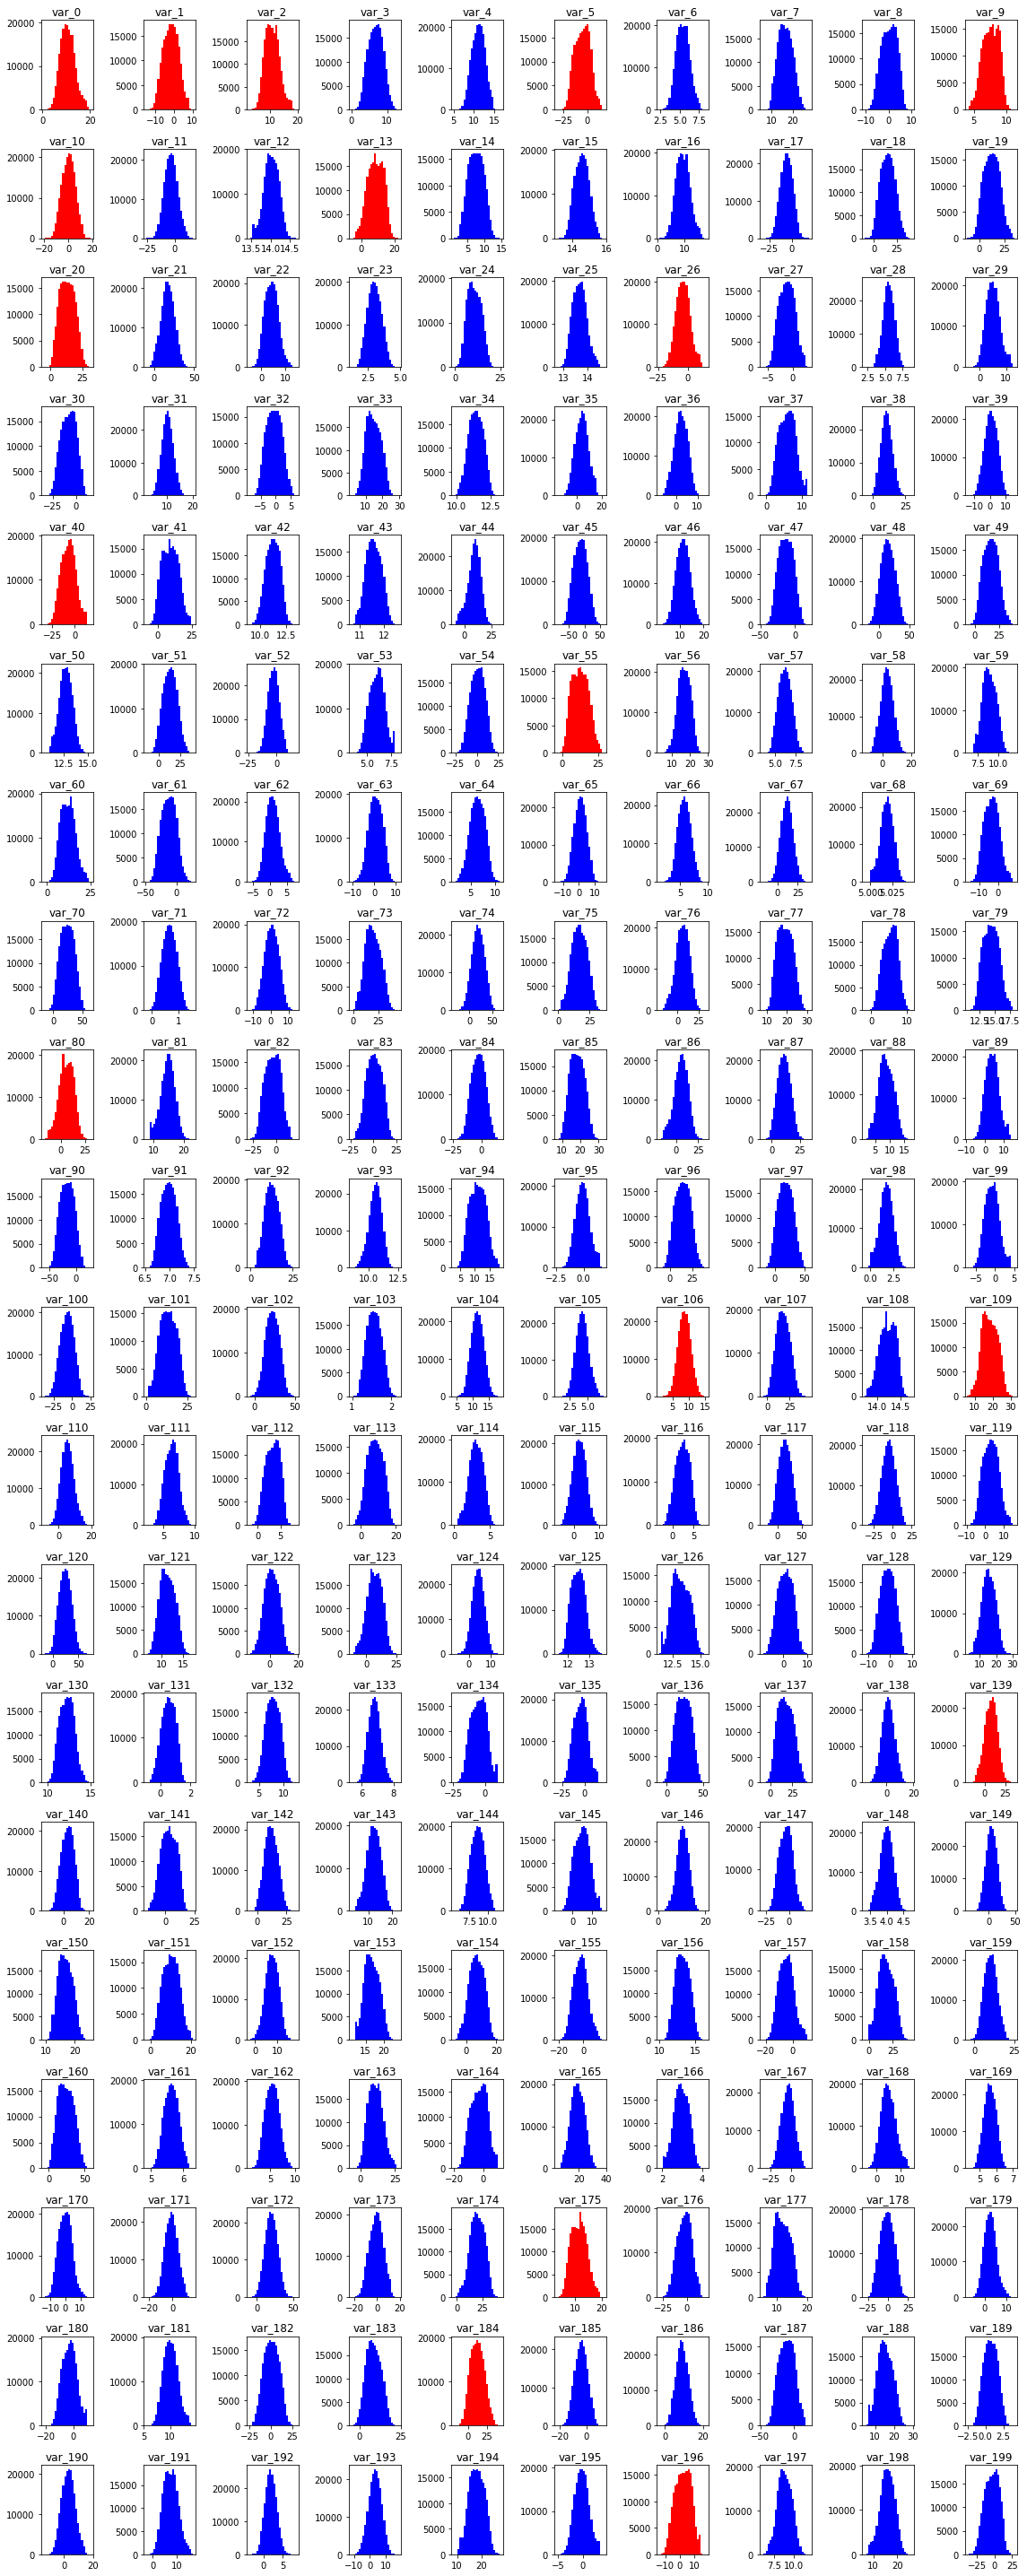

In [103]:
# continuous_feature = train_df.columns[2:]

plot_distributions(train_df, NUMERICAL_FEATS, mode='Train')

Test features distribution


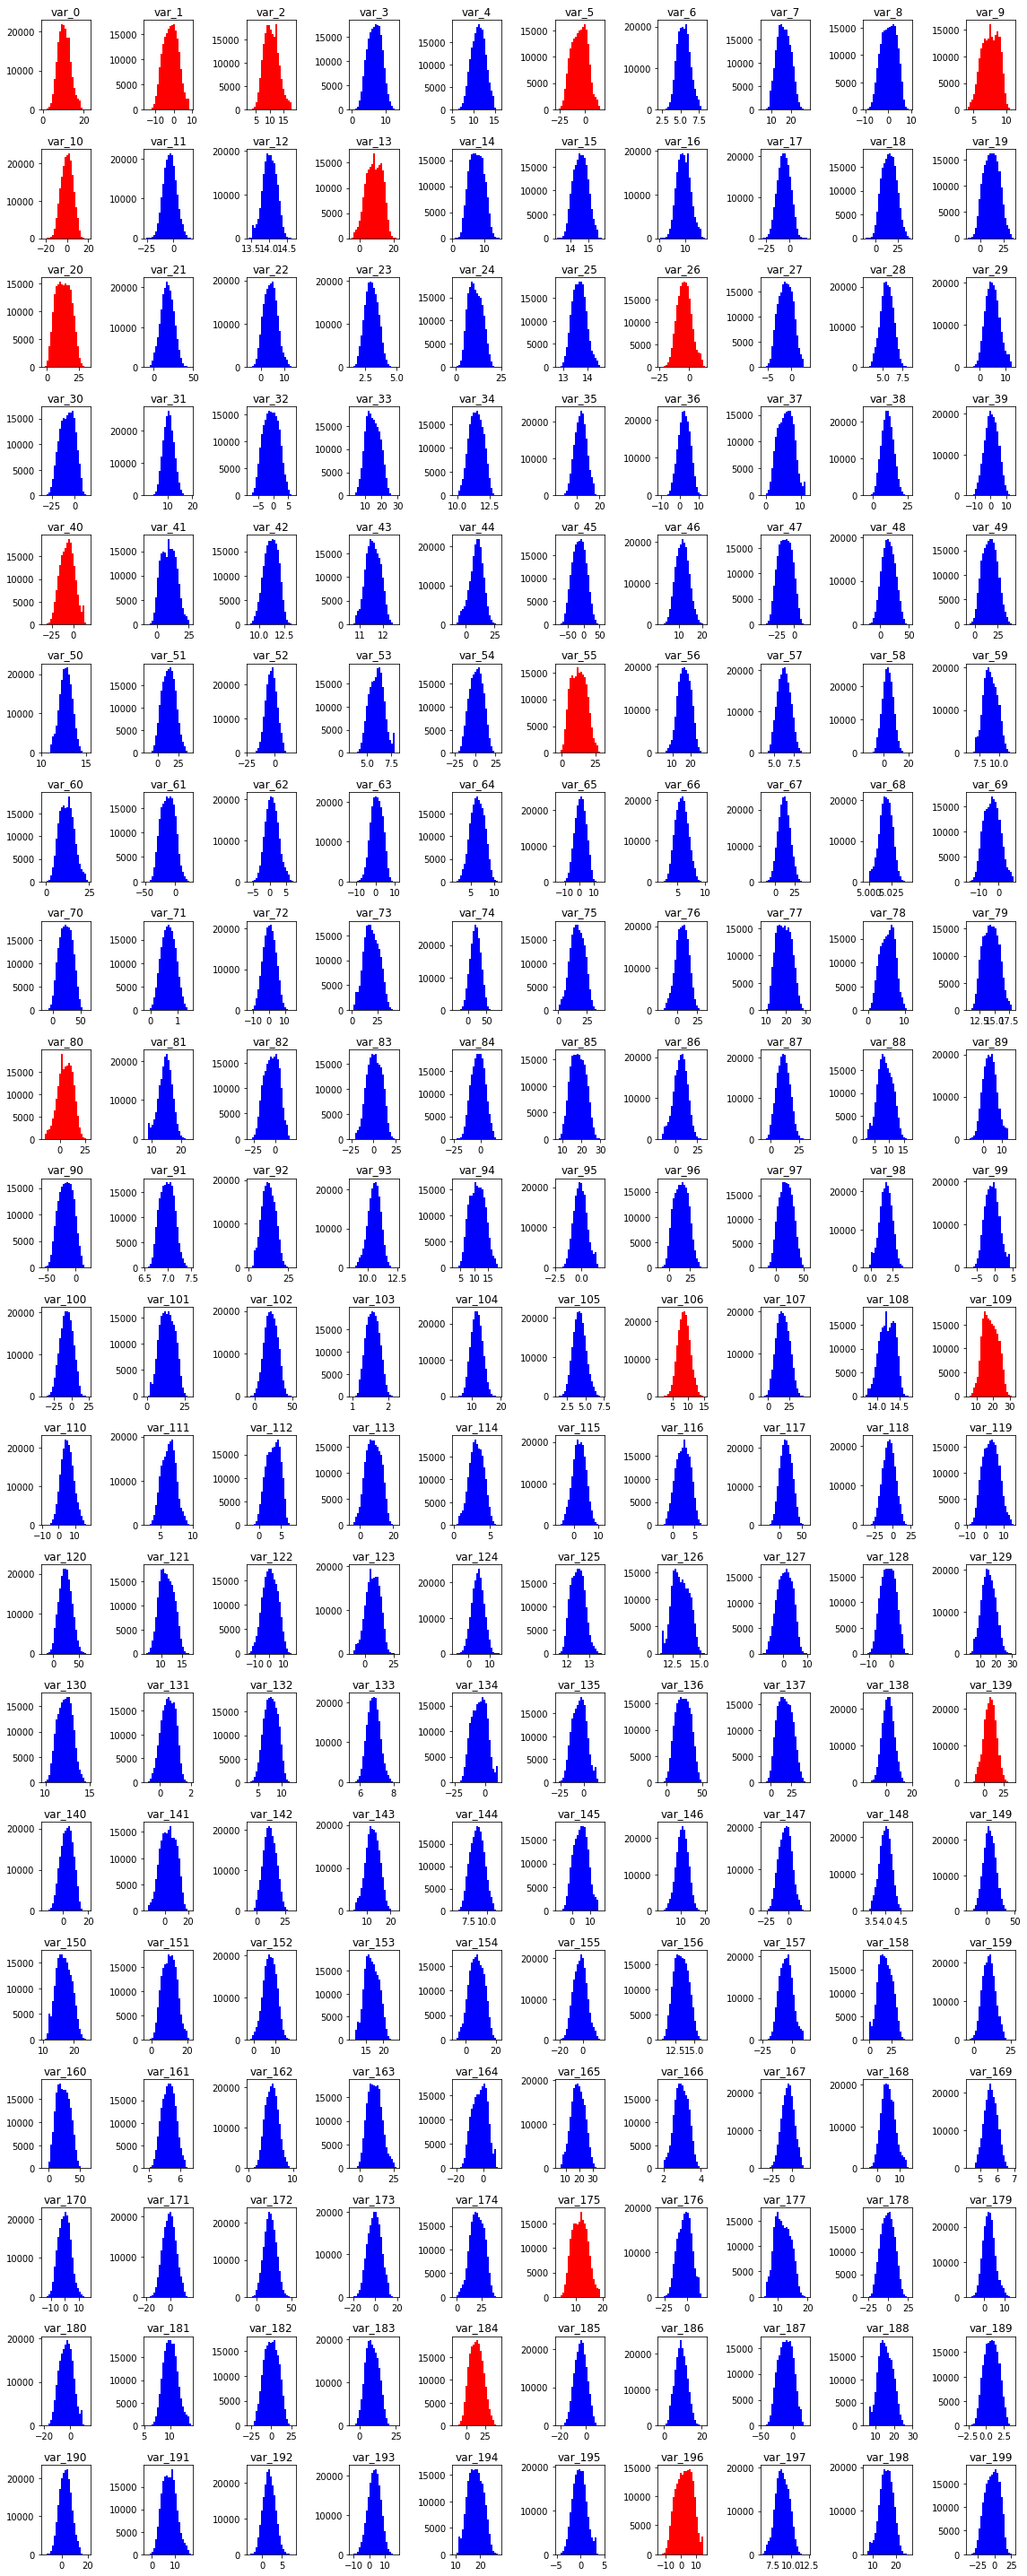

In [104]:
plot_distributions(test_df, NUMERICAL_FEATS, mode='Test')

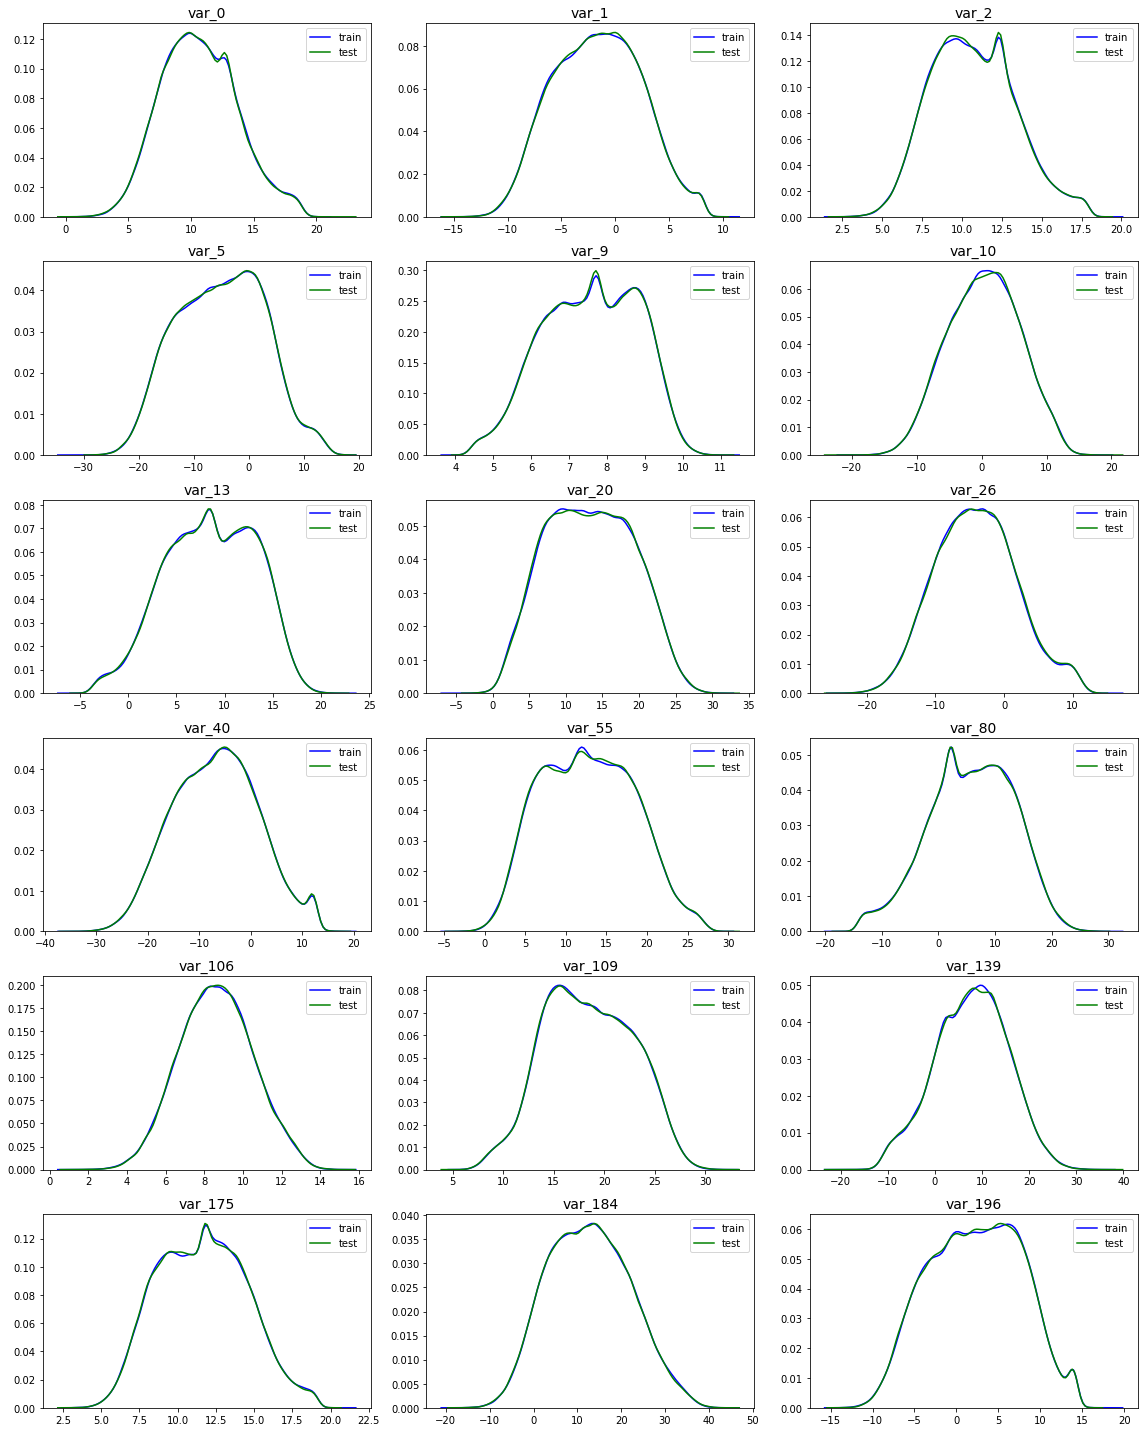

In [114]:
plot_compare_distributions(train_df, test_df, features=TARGET_FEATS)

In [7]:
train_df

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,4.6667,3.8743,-5.2387,7.3746,11.5767,12.0446,11.6418,-7.0170,5.9226,-14.2136,16.0283,5.3253,12.9194,29.0460,-0.6940,5.1736,-0.7474,14.8322,11.2668,5.3822,2.0183,10.1166,16.1828,4.9590,2.0771,-0.2154,8.6748,9.5319,5.8056,22.4321,5.0109,-4.7010,21.6374,0.5663,5.1999,8.8600,43.1127,18.3816,-2.3440,23.4104,6.5199,12.1983,13.6468,13.8372,1.3675,2.9423,-4.5213,21.4669,9.3225,16.4597,7.9984,-1.7069,-21.4494,6.7806,11.0924,9.9913,14.8421,0.1812,8.9642,16.2572,2.1743,-3.4132,9.4763,13.3102,26.5376,1.4403,14.7100,6.0454,9.5426,17.1554,14.1104,24.3627,2.0323,6.7602,3.9141,-0.4851,2.5240,1.5093,2.5516,15.5752,-13.4221,7.2739,16.0094,9.7268,0.8897,0.7754,4.2218,12.0039,13.8571,-0.7338,-1.9245,15.4462,12.8287,0.3587,9.6508,6.5674,5.1726,3.1345,29.4547,31.4045,2.8279,15.6599,8.3307,-5.6011,19.0614,11.2663,8.6989,8.3694,11.5659,-16.4727,4.0288,17.9244,18.5177,10.7800,9.0056,16.6964,10.4838,1.6573,12.1749,-13.1324,17.6054,11.5423,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,10.8160,3.6783,-11.1147,1.8730,9.8775,11.7842,1.2444,-47.3797,7.3718,0.1948,34.4014,25.7037,11.8343,13.2256,-4.1083,6.6885,-8.0946,18.5995,19.3219,7.0118,1.9210,8.8682,8.0109,-7.2417,1.7944,-1.3147,8.1042,1.5365,5.4007,7.9344,5.0220,2.2302,40.5632,0.5134,3.1701,20.1068,7.7841,7.0529,3.2709,23.4822,5.5075,13.7814,2.5462,18.1782,0.3683,-4.8210,-5.4850,13.7867,-13.5901,11.0993,7.9022,12.2301,0.4768,6.8852,8.0905,10.9631,11.7569,-1.2722,24.7876,26.6881,1.8944,0.6939,-13.6950,8.4068,35.4734,1.7093,15.1866,2.6227,7.3412,32.0888,13.9550,13.0858,6.6203,7.1051,5.3523,8.5426,3.6159,4.1569,3.0454,7.8522,-11.5100,7.5109,31.5899,9.5018,8.2736,10.1633,0.1225,12.5942,14.5697

### Оценка пропусков

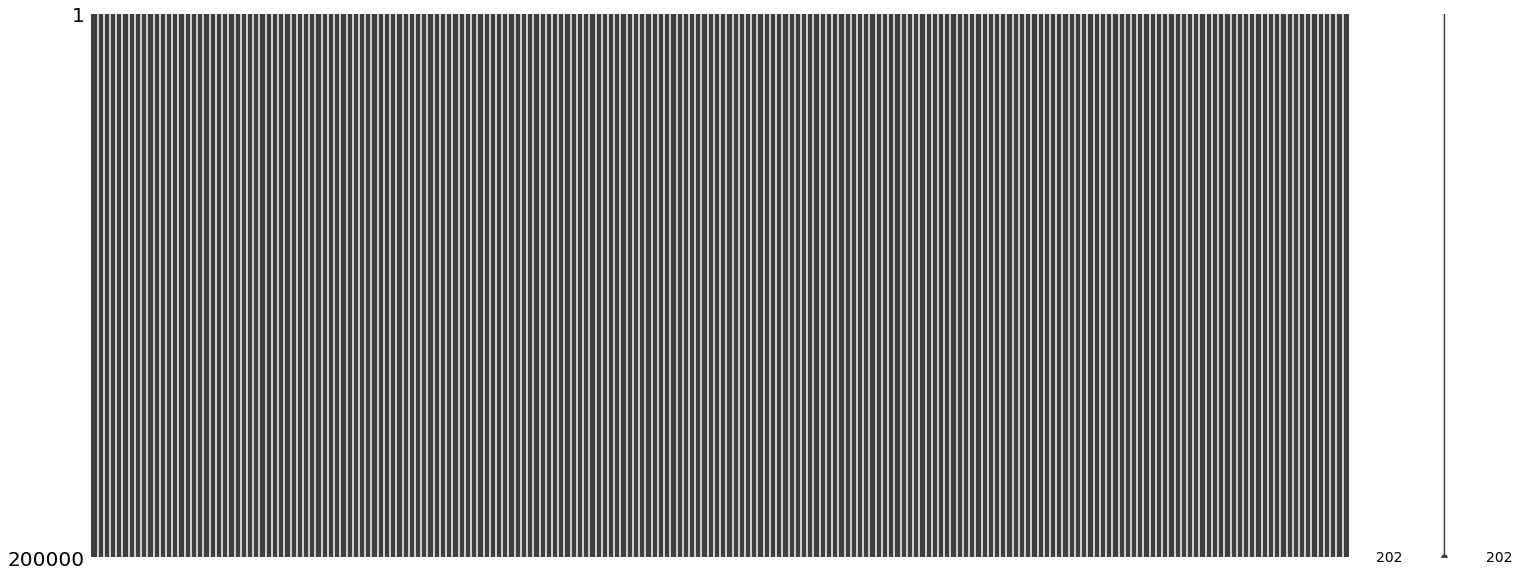

In [118]:
# NaN showplot
msno.matrix(train_df);

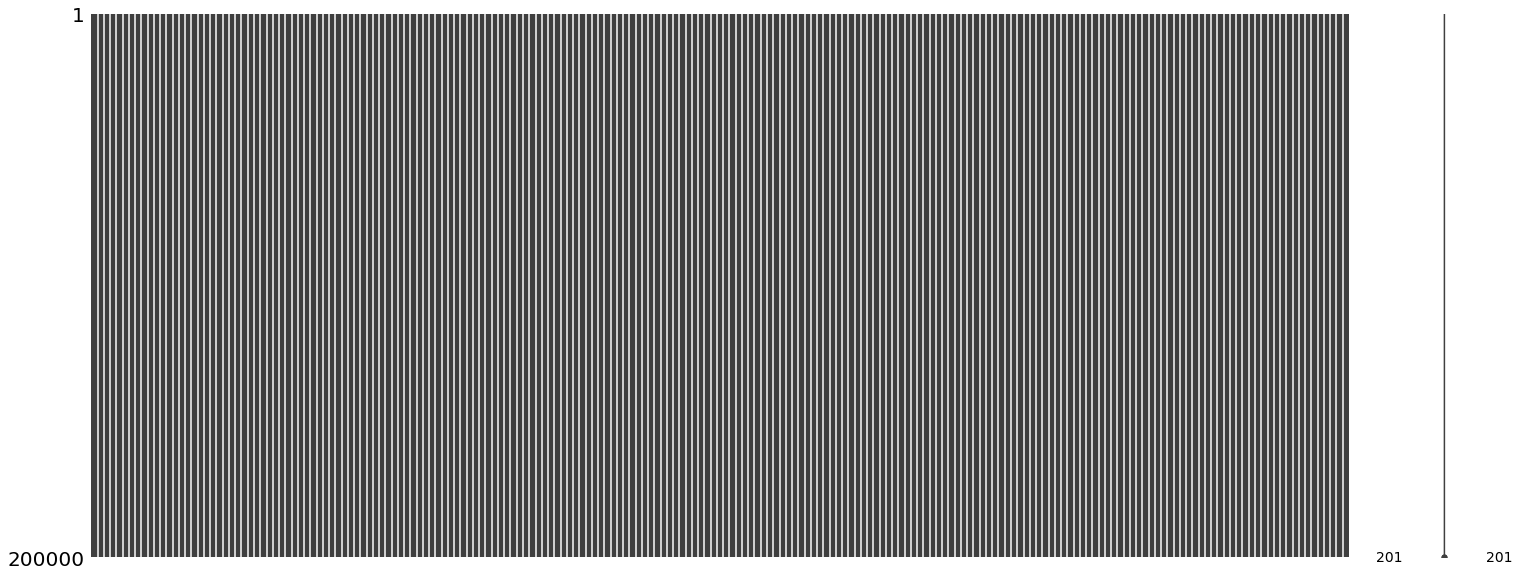

In [119]:
# NaN showplot
msno.matrix(test_df);

### Анализ распределения целевой переменной

Видно смещение баланса таргета в торону 0 метки (в целом, при соотношении 0.1 можно работать без балансировки)

In [182]:
train_df[TARGET].value_counts()

0    179902
1     20098
Name: target, dtype: int64

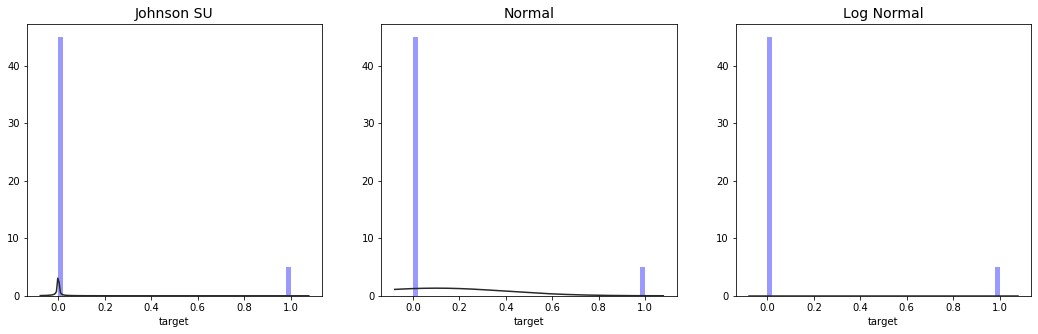

In [14]:
target = train_df[TARGET]
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].set_title("Johnson SU", fontsize=14)
sns.distplot(target, kde=False, color="blue", fit=st.johnsonsu, ax=axes[0])

axes[1].set_title("Normal", fontsize=14)
sns.distplot(target, kde=False, color="blue", fit=st.norm, ax=axes[1])

axes[2].set_title("Log Normal", fontsize=14)
sns.distplot(target, kde=False, color="blue", fit=st.lognorm, ax=axes[2])

In [9]:
# target = train_df[TARGET]
# fig = plt.figure(figsize=(13, 5))
# plt.subplot(121)
# sns.distplot(target, bins=15, color="blue")
# plt.subplot(122)
# probplot(target, plot=plt)
# plt.show()

### Корреляция признаков с целевой переменной

In [122]:
# msno.heatmap(train_df); # No null values

In [202]:
correlation = train_df[ALL_NUMERICAL_FEATS].corr()
corr_with_target = correlation[TARGET].sort_values(ascending = False)
corr_with_target[:10]

target     1.000000
var_6      0.066731
var_110    0.064275
var_53     0.063399
var_26     0.062422
var_22     0.060558
var_99     0.058367
var_190    0.055973
var_2      0.055870
var_133    0.054548
Name: target, dtype: float64

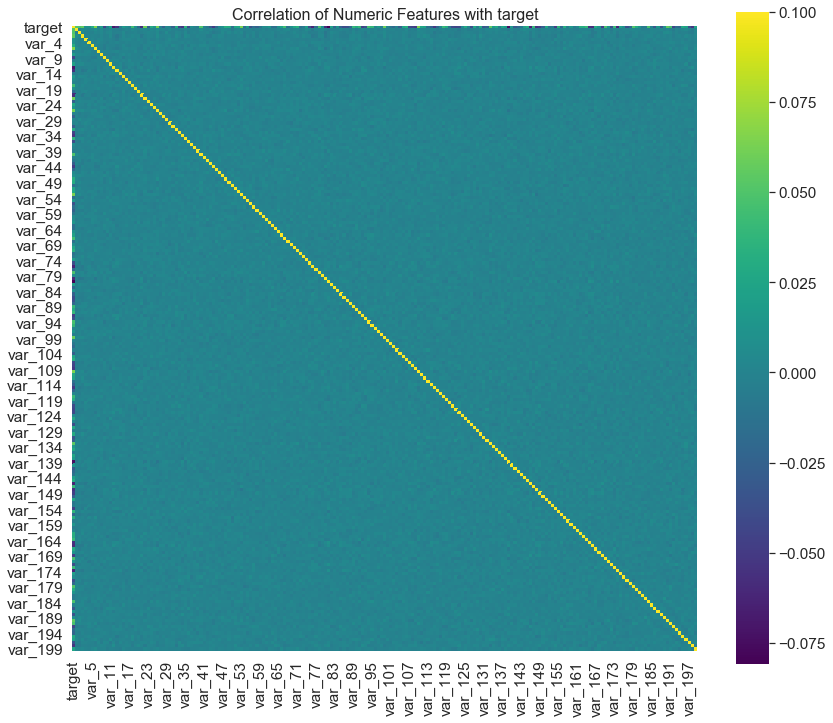

In [205]:
fig, axes = plt.subplots(figsize = (14,12))
plt.title("Correlation of Numeric Features with target", y=1, size=16)
sns.heatmap(correlation, square=True, vmax=0.1, cmap="viridis")

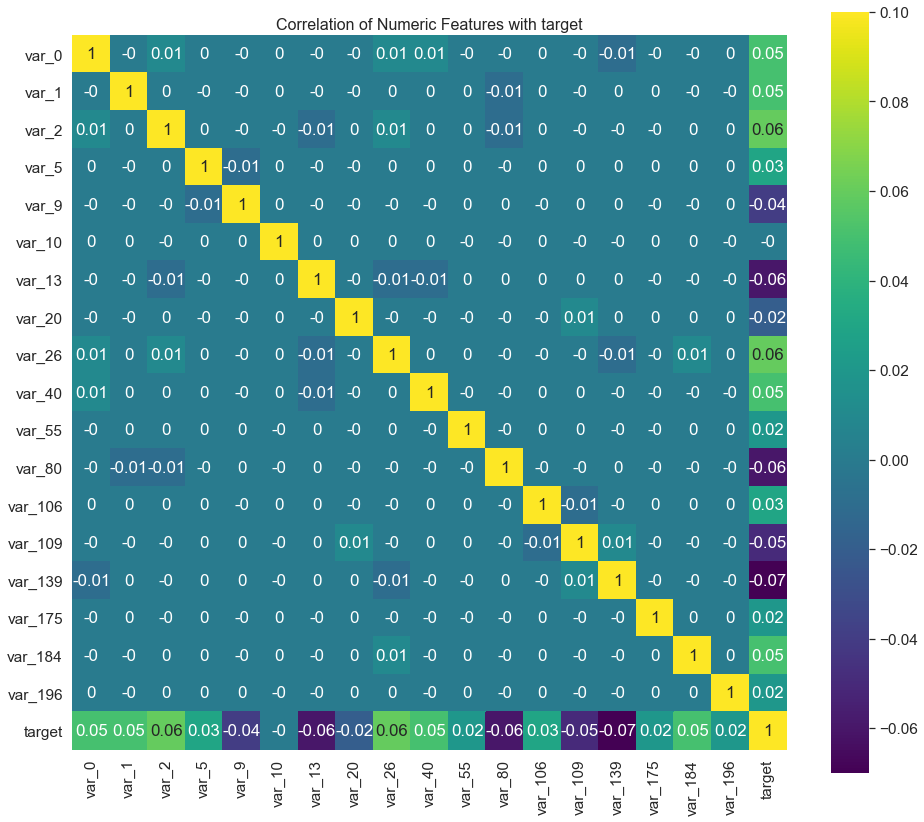

In [190]:
fig, axes = plt.subplots(figsize = (16,14))
plt.title("Correlation of Numeric Features with target", y=1, size=16)
sns.heatmap(train_df[ALL_TARGET_FEATS].corr().round(2), square=True, vmax=0.1, cmap="viridis", annot=True);

Text(0, 0.5, 'Density')

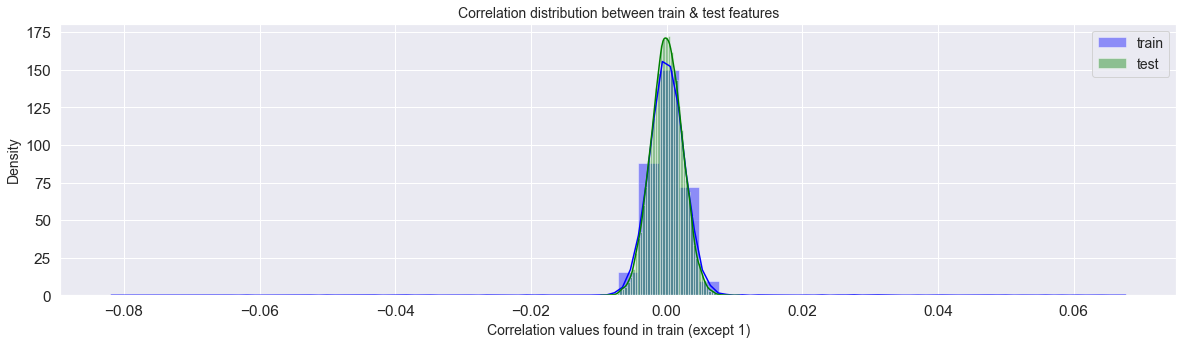

In [191]:
train_correlations = train_df[ALL_NUMERICAL_FEATS].corr()
train_correlations = train_correlations.values.flatten()
train_correlations = train_correlations[train_correlations != 1]

test_correlations = test_df[NUMERICAL_FEATS].corr()
test_correlations = test_correlations.values.flatten()
test_correlations = test_correlations[test_correlations != 1]

plt.figure(figsize=(20,5))
sns.distplot(train_correlations, color="Blue", label="train")
sns.distplot(test_correlations, color="Green", label="test")

plt.xlabel("Correlation values found in train (except 1)", size=14)
plt.title("Correlation distribution between train & test features", size=14)
plt.legend(loc="best", fontsize=14)
plt.ylabel("Density", size=14)

### Анализ нелинейной связи между признаками

In [15]:
%%time
parameters = {"max_depth": 6, "n_estimators": 25, "random_state": 27, "n_jobs": -1}

forest = RandomForestClassifier(**parameters)
forest.fit(train_df[NUMERICAL_FEATS], train_df[TARGET])

Wall time: 18.2 s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=-1,
                       oob_score=False, random_state=27, verbose=0,
                       warm_start=False)

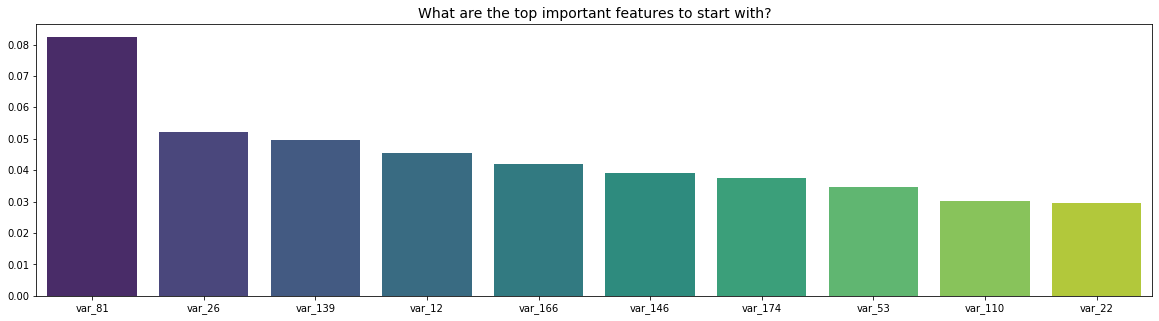

In [16]:
n_top = 10
importances = forest.feature_importances_
idx = np.argsort(importances)[::-1][0:n_top]
# feature_names = numerical_features.drop("SalePrice", axis=1).columns

plt.figure(figsize=(20, 5))
sns.barplot(x=NUMERICAL_FEATS[idx], y=importances[idx], palette="viridis")
plt.title("What are the top important features to start with?", size=14);

Выделяем топ-10 фич для дальнейшего анализа

In [17]:
TOP_10_FEATS = list(NUMERICAL_FEATS[idx])
TOP_10_FEATS

['var_81',
 'var_26',
 'var_139',
 'var_12',
 'var_166',
 'var_146',
 'var_174',
 'var_53',
 'var_110',
 'var_22']

### Pair Plot

Парные графики зависимостей топ-10 отобранных фич с целевой переменной 

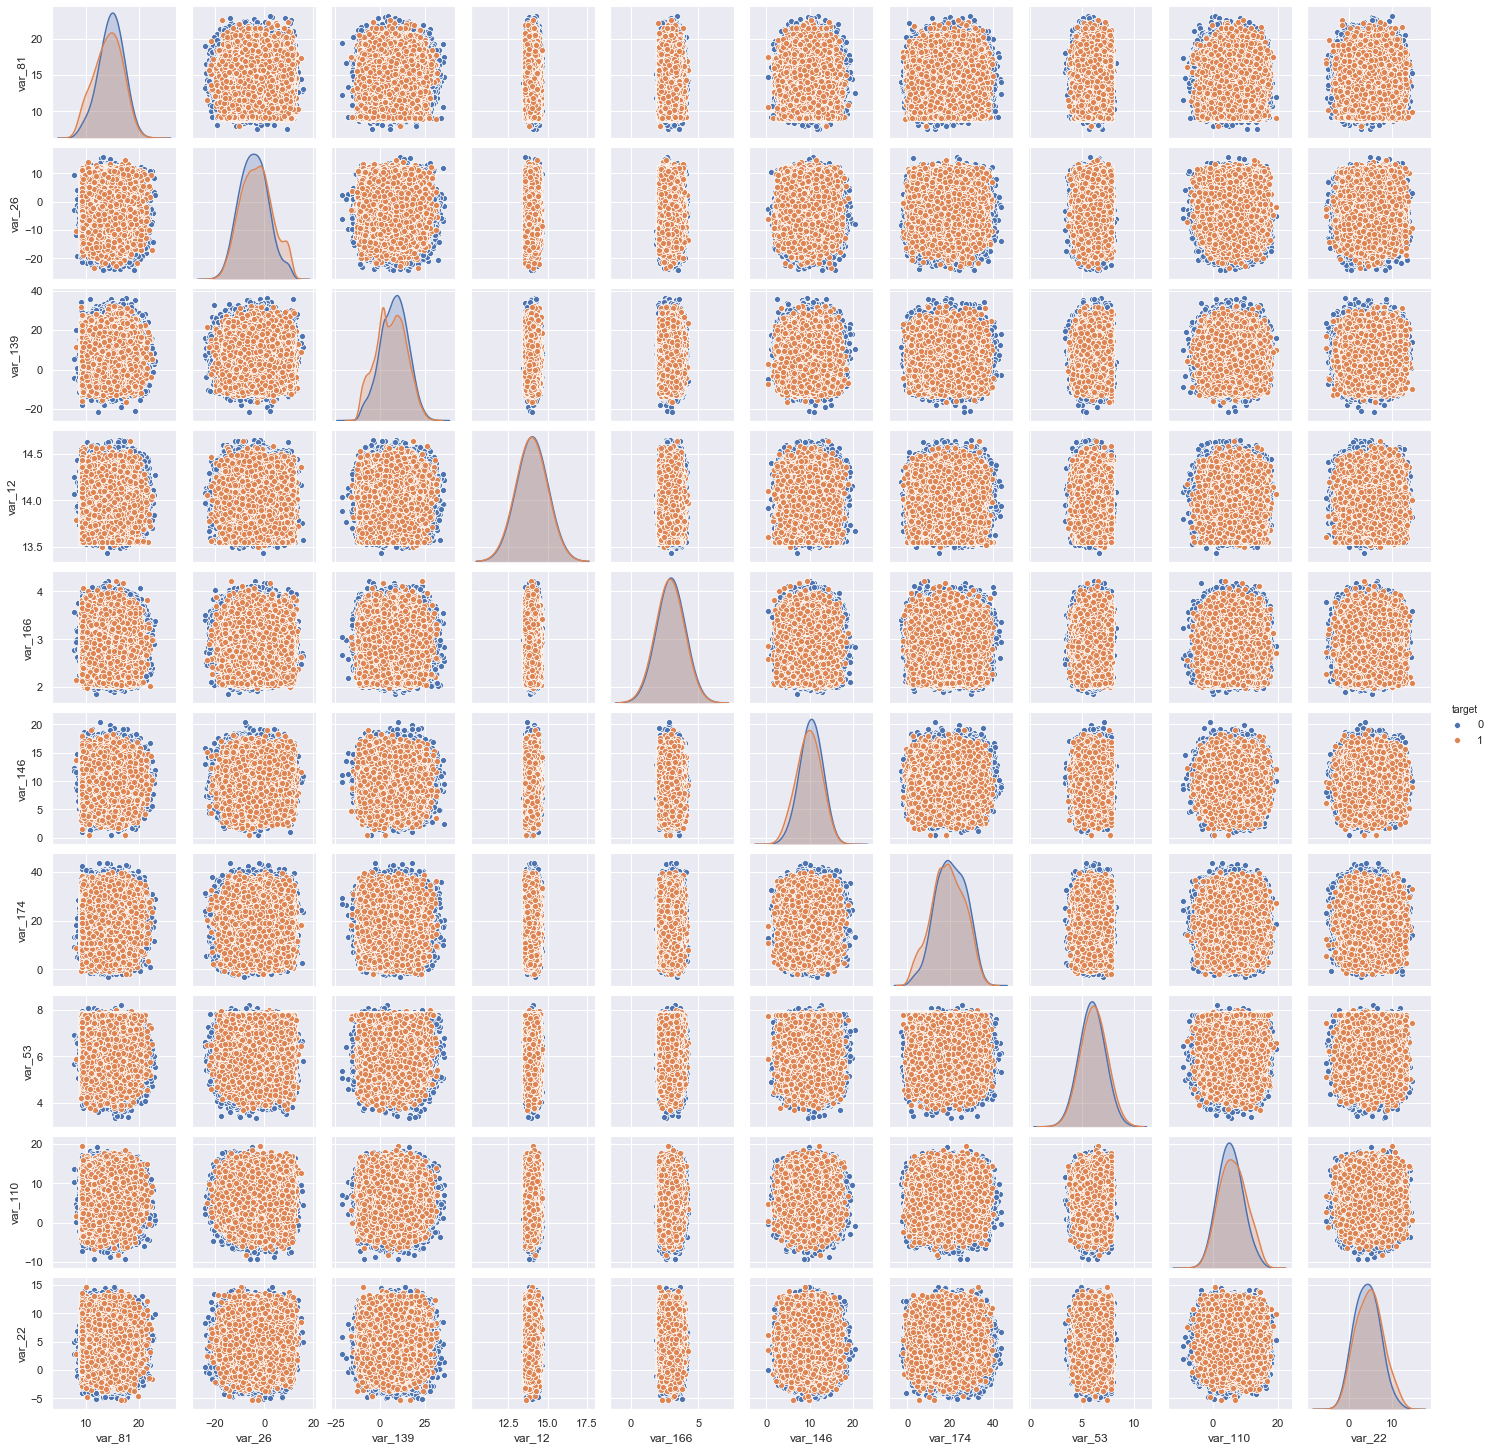

In [40]:
sns.set()

columns = [TARGET] + TOP_10_FEATS

sns.pairplot(train_df[columns], height=2, kind="scatter", diag_kind="kde", diag_kws={'bw':'1.0'}, hue='target')
plt.show()

## Scatter Plot

Scatter-plot'ы между наиболее скореллированными признаками показали отсутствие линейной связи с целевой переменной

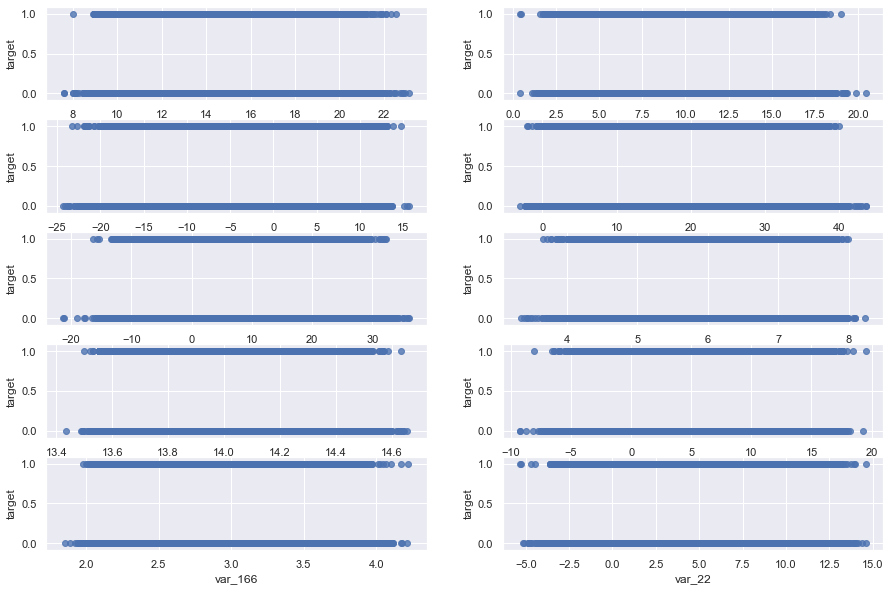

In [37]:
fig, axes = plt.subplots(5, 2, figsize=(15, 10))
for num, feature in enumerate(train_df[TOP_10_FEATS]):
    sns.regplot(
        x=feature,
        y="target",
        data=train_df,
        ax=axes[num%5, num//5],
        scatter=True,
        fit_reg=False
    )

## Box & Violin Plots

#### Распределение статистик топ-10 признаков в разрезе целевой переменной

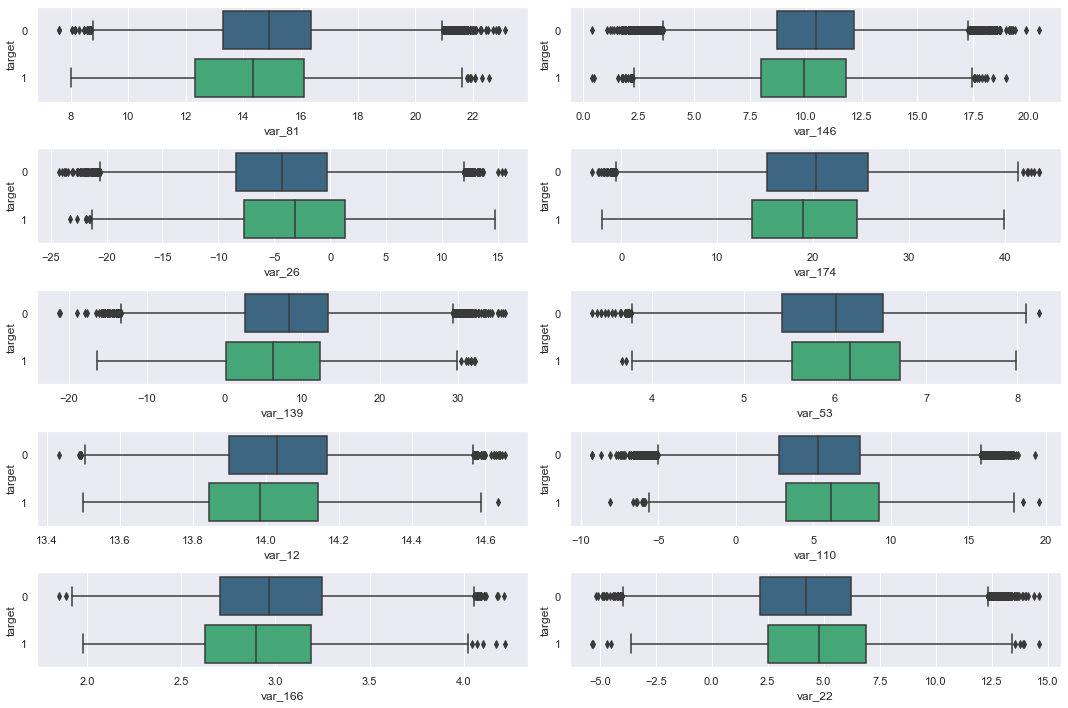

In [38]:
fig, axes = plt.subplots(5, 2, figsize=(15, 10))

for num, feature in enumerate(train_df[TOP_10_FEATS]):
    sns.boxplot(y="target",
                x=feature,
                data=train_df[train_df[TARGET].isin(classes)],
                orient="h",
                ax=axes[num%5, num//5],
                palette='viridis'
               )
fig.tight_layout()

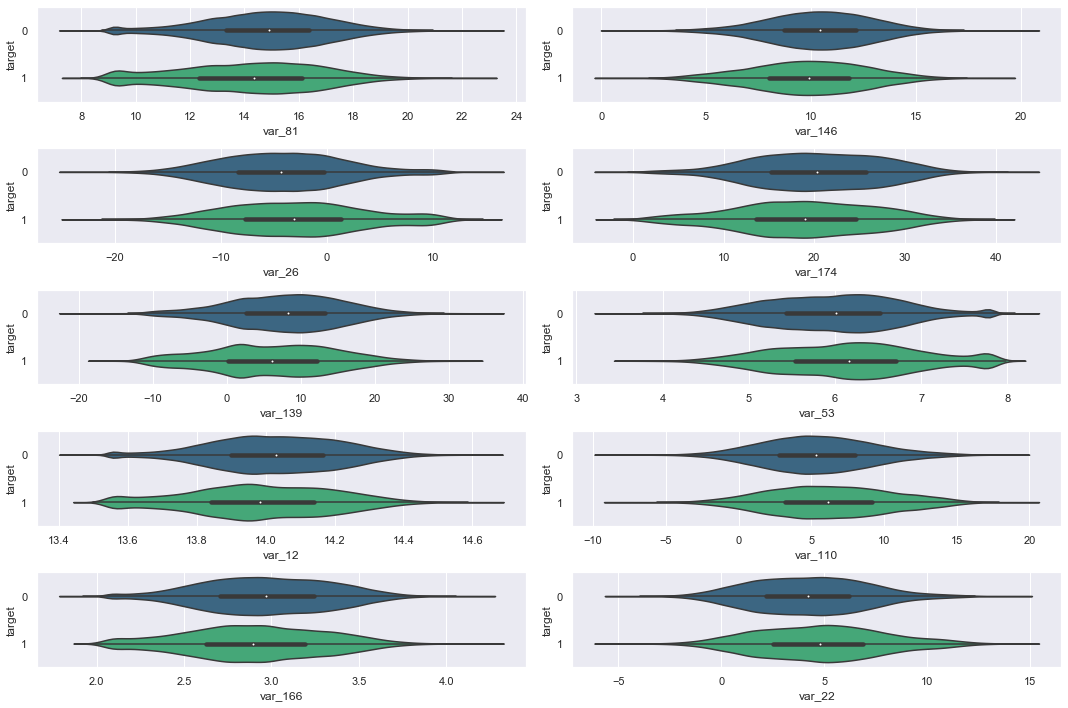

In [41]:
fig, axes = plt.subplots(5, 2, figsize=(15, 10))

for num, feature in enumerate(train_df[TOP_10_FEATS]):
    sns.violinplot(y="target",
                   x=feature,
                   data=train_df[train_df[TARGET].isin(classes)],
                   orient="h",
                   ax=axes[num%5, num//5],
                   palette='viridis'
                  )
fig.tight_layout()

## Анализ распределения на обучении и тесте

Совпадение распределений на выборке для обучения и для тестирования - одна из ключевых коцепций статистического обучения. Обучая модель на некоторых данных, мы принимаем гипотезу о том, что модель должна работать на таких же данных.

### Kolmogorov-Smirnov Test

Распределение статистик для train и test практически идентично 

Значения p-value для всей выборки колеблятся в пределах 0.032-0.086. Формально для фич p-value < 0.05 принятая гипотеза отвергается. По факту все значения p-value находятся на нижней границе, поэтому работоспособность гипотезы на текущих данных сомнительна.

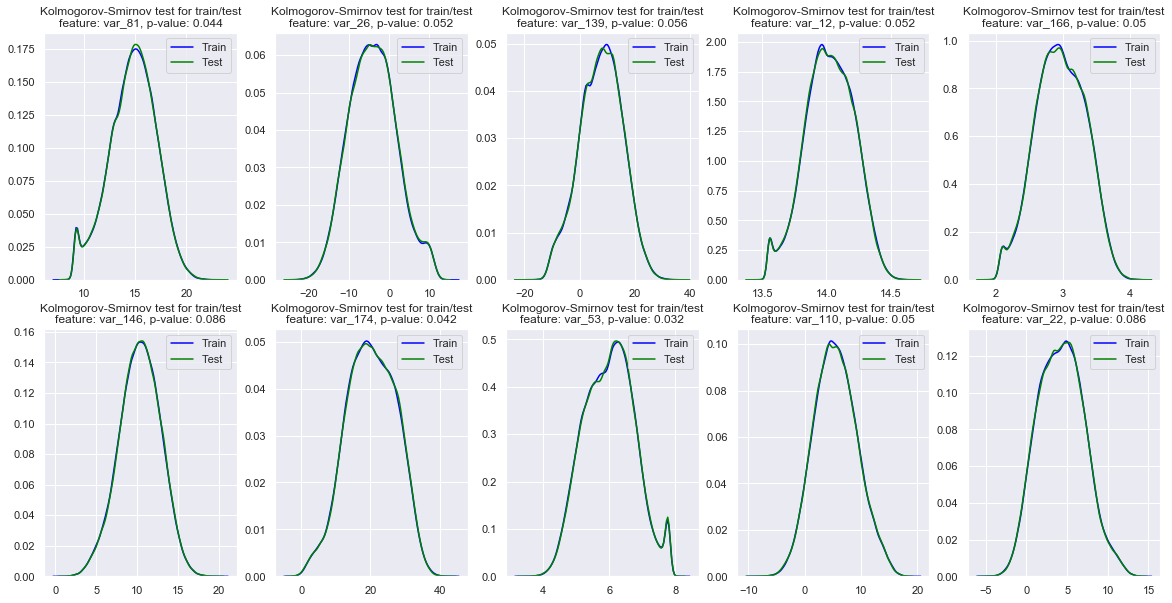

In [235]:
statistics_array = []
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

for num, feature in enumerate(train_df[TOP_10_FEATS]):
    statistic, pvalue = ks_2samp(
        train_df[feature].sample(500), test_df[feature].sample(500)
    )
    statistics_array.append(statistic)

    sns.kdeplot(train_df[feature], ax=axes[num//5, num%5], color="Blue", label="Train")
    sns.kdeplot(test_df[feature], ax=axes[num//5, num%5], color="Green", label="Test")

    axes[num//5, num%5].set_title(
        (f"Kolmogorov-Smirnov test for train/test\n"
        f"feature: {feature}, p-value: {round(statistic, 3)}")
    )

### Adversarial Validation

In [257]:
# train + test union

X_adv = pd.concat([
    train_df[NUMERICAL_FEATS], test_df[NUMERICAL_FEATS]
])
y_adv = np.hstack(
    (np.ones(train_df.shape[0]), np.zeros(test_df.shape[0])))

X_adv = X_adv.reset_index(drop=True)

In [259]:
%%time
parameters = {"max_depth": 4, "n_estimators": 50, "random_state": 27, "n_jobs": -1}
model = xgb.XGBClassifier(**parameters)

cv = cross_val_score(
    estimator=model,
    X=X_adv, y=y_adv,
    scoring="roc_auc",
    cv=KFold(n_splits=3, shuffle=True, random_state=27)
)

print(f"CV-score: {round(np.mean(cv), 4)}")

CV-score: 0.5116
Wall time: 5min 52s


Text(0.5, 1.0, 'Top Importance Features for Adversarial Validation (train vs test)')

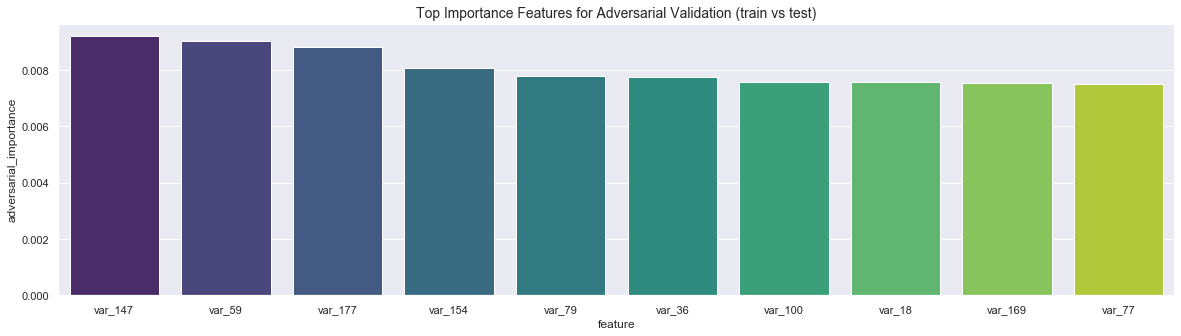

In [260]:
model.fit(X_adv, y_adv)

importance = pd.DataFrame({
    "feature": X_adv.columns,
    "adversarial_importance": model.feature_importances_
})
importance = importance.sort_values(by="adversarial_importance", ascending=False)
importance = importance.head(n=10)

plt.figure(figsize=(20, 5))
sns.barplot(x=importance["feature"], y=importance["adversarial_importance"], palette="viridis")
plt.title("Top Importance Features for Adversarial Validation (train vs test)", size=14)

##### Выводы:
- Датасет не содержит пропусков
- **200 непрерывных признаков**. Единственный номенативный признак - **ID_code**. Можно перевести в числовой формат
- Как тренеровочные, так и тестовые признаки имеют **Гауссово распределение**, 
- **Train** и **Test** имеют крайне **схожее распределение** и отличаются между собой наличием случайных **шумов**
- Можно считать, что **линейная связь** между признаками **отсутствует**. Нелинейная связь также крайне слаба
- Целевой признак **target** дискретный, имеет 2 класса, несбалансирован (отношение 1 класса к 0 порядка **11%**)
- Тест Колмогорова-Смирнова показал, что нулевая гипотеза отвергается практически всегда, данный показатель не релевантен текущему датасету
- Тест по Adversarial Validation показал, что распределения train-test схожи, их можно использовать в обучении.

В целом, данные представляют собой набор шумов, их природа похожа на **сгенерированные облака точек** по закону **нормального распределения** с незначительными вариациями статистик по фичам с последующим разделением на train и test  (о чем говорит крайняя схожесть статистик). **Взаимосвязь target-меток с признаками околонулевая**, в контексте текущих признаков можно предположить, что метки классов были **присвоены случайным образом** при **фиксированном смещении**.